# 1. Predicting Change in Sentiments

The goal of this section is to predict the change in the sentiment given the current utternace and the sentiment of the previous utterance. The inputs of the prediction model are the utterance encoded along with a real number for the pre
To encode the incoming messages, I used GloVe 50 dimentional vectors for each word in the message; these vectors were then averaged resulting in a vector of 50 dimensional. In total the input of the model is a vector of size 51. For this part, I used linear regression, support vector regression, and random forest for my models. The output of the models are also a real number between -2 and +2. 

## 1.1 Metric of Evaluation
I used mean square error to compare performace of different models.

## 1.2 Models

### 1.2.1 Linear Regression
I traind linear regression once with all the 51 features and recorded the mean square error and R^2 score for the test set. Another time, I used PCA to reduce the number of features from 51 to 34 by keeping %95 of variance. However I did not see any improvement or decay in the performance.

### 1.2.2 Support Vector Regression
I was not able to train a svm for this dataset even with a reduced number of features. The problem is with the size of dataset and the fact that svm does not scale well with the size of data.

### 1.2.3 Random Foreset
I trained a random forest with 100 estimator with all the 51 features 

### 1.2.4 Recurrent Neural Network (LSTM)

In [25]:
from utility import *

from sklearn import metrics
from sklearn import svm
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import resample


In [2]:
def sentence_to_avg(sentence, word_to_vec_map):
    '''
    this function creates a vector of 50d for an input sentence
    by average all the word vectors in the sentence
    '''
    sentence = re.sub(r'[^\w\s]', ' ', sentence.strip())  
    words = [i.lower() for i in sentence.strip().split()]
    avg = np.zeros((50,))
    
    if len(words) == 0: 
        print(sentence)
        return None
    
    for w in words:
        vec = word_to_vec_map[w] if w in word_to_vec_map else word_to_vec_map['unk'] 
        avg += vec
    avg = avg / len(words)
        
    return avg

In [3]:
def fit_svm_model(x_train, y_train):
    # train svm
    
    clf = svm.SVR(kernel='linear', C=1000)
    clf.fit(x_train, y_train)
    return clf

In [4]:
def fit_random_forest_model(x_train, y_train):
    # train random forest
    model = RandomForestRegressor(n_estimators=100, random_state=42) 
    model.fit(x_train, y_train)
    return model

In [5]:
def fit_regression_model(x_train, y_train):
    # train linear regression
    
    model = linear_model.LinearRegression()
    model.fit(x_train, y_train)
    return model

In [6]:
def create_features(samples_list):
    '''
    this function creates features for each conversation
    '''
    x, y = [], []
    for sample in samples_list:
        vec = sentence_to_avg(sample['utterance'], word_to_vec_map)
        if vec is None: continue
        
        vec = vec.tolist()
        vec.append(sample['current_emotion'])
        
        x.append(vec)
        y.append(sample['current_emotion'] - sample['prev_emotion'])
    
    return x, y

In [7]:
# load glove.6B 50d
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B/glove.6B.50d.txt')

In [8]:
# loading train, test and validation sets
train_conversations = load_conversations(category='train')
find_sentiments(train_conversations)

test_conversations = load_conversations(category='test')
find_sentiments(test_conversations)

validation_conversations = load_conversations(category='validation')
find_sentiments(validation_conversations)

In [36]:
train_samples = create_samples(train_conversations)
x_train, y_train = create_features(train_samples)

test_samples = create_samples(test_conversations)
x_test, y_test = create_features(test_samples)

In [10]:
print('Number of training samples: ', len(x_train), len(y_train), 'Number of features: ', len(x_train[0]))

Number of training samples:  76051 76051 Number of features:  51


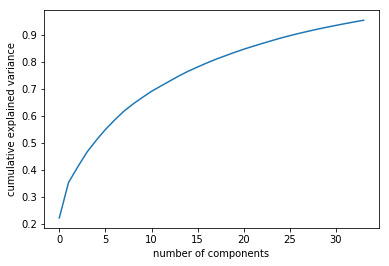

In [11]:
# pca to reduce number of features with a variance = %95
pca = PCA(n_components=0.95, svd_solver='full')
pca.fit(x_train)
new_x_train = pca.transform(x_train)   
new_x_test = pca.transform(x_test)    
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [12]:
# random forest with 51 features
rfModel = fit_random_forest_model(x_train, y_train)
y_pred = rfModel.predict(x_test)   
print("Mean squared error: %.2f"% mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Mean squared error: 0.07


In [15]:
# regression model
rgModel = fit_regression_model(x_train, y_train)
y_pred = rgModel.predict(x_test)
print('Coefficients: \n', rgModel.coef_)    
print("Mean squared error: %.2f"% mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [-0.05518255 -0.09586653  0.02818487  0.01035777  0.0116708   0.04732483
  0.00779986  0.06017013  0.02364771  0.00432414 -0.122796    0.09142667
  0.01239393  0.00719745  0.02650578  0.03638743 -0.03397658  0.04212108
 -0.00732165  0.07830698 -0.0605946  -0.00650555 -0.032918    0.01033865
 -0.06733058 -0.00742075  0.01750965  0.02583285  0.02104933  0.03763537
  0.01567542  0.03409339  0.02973543 -0.07539445 -0.00222797 -0.08600382
  0.06424077 -0.00221389  0.02712701  0.07966255  0.03911491  0.01164392
  0.01512918  0.01352975  0.03294507 -0.00647605  0.05839532  0.01001226
  0.01446369 -0.06615325  0.9229181 ]
Mean squared error: 0.08
Variance score: 0.46


In [16]:
# linear regression with l1 regularization
regModel_Lasso = linear_model.Lasso(alpha=0.1)
regModel_Lasso.fit(x_train, y_train)
y_pred = regModel_Lasso.predict(x_test)
print('Coefficients: \n', regModel_Lasso.coef_)    
print("Mean squared error: %.2f"% mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [-0.  0. -0.  0.  0. -0. -0. -0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.
  0. -0. -0.  0. -0. -0.  0. -0. -0.  0.  0. -0.  0.  0.  0. -0.  0. -0.
 -0.  0. -0. -0.  0.  0. -0. -0. -0.  0.  0.  0.  0.  0.  0.]
Mean squared error: 0.16
Variance score: -0.00


In [19]:
# regression model with a reduced number of features
rgModel_PCA = fit_regression_model(new_x_train, y_train)
y_pred = rgModel_PCA.predict(new_x_test)
print('Coefficients: \n', rgModel_PCA.coef_)    
print("Mean squared error: %.2f"% mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [-0.01588763 -0.01961595  0.11603304  0.23784433 -0.21233813 -0.48977211
  0.35331376 -0.09234219 -0.21640386  0.0998127  -0.30396224  0.2075275
  0.07616187 -0.30565344 -0.00909076 -0.01723262 -0.03074026  0.18717432
 -0.07100299 -0.04446019 -0.03955126  0.08211716  0.06333477 -0.04804121
 -0.00297954 -0.02521183 -0.00679153  0.09885389 -0.08641928  0.01576869
  0.01131894  0.03226107 -0.04156359  0.02640871]
Mean squared error: 0.08
Variance score: 0.46


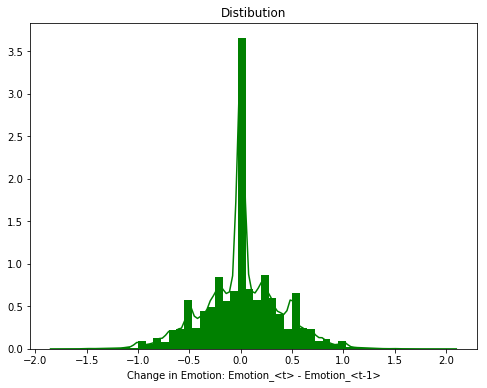

In [51]:
# distribution of change in emotion
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(y_train, kde=True, color='green', hist_kws=dict(alpha=1))
plt.xlabel('Change in Emotion: Emotion_<t> - Emotion_<t-1>')
plt.title('Disribution of Outcome')
plt.show()

In [ ]:
# downsample majority output: emotion=0
data = {}
data['input'] = x_train
data['output'] = y_train
data_df = pd.DataFrame(data)

label_25 = data_df[data_df.output == 0.25]
non_zero_label = data_df[data_df.output != 0]
zero_label = data_df[data_df.output == 0]

# Downsample majority label: emotion=0.0
df_zeros_downsampled = resample(zero_label, 
                               replace=False,    # sample without replacement
                               n_samples=label_25.count()[0],     # to match minority class
                               random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_zeros_downsampled, non_zero_label])
 

In [68]:
# Display new class counts
print("Downsampled: ", df_downsampled.count())

downsampled_y_train = df_downsampled['output']
downsampled_x_train = df_downsampled['input']

downsampled_x_train = downsampled_x_train.values.tolist()

# regression model after downsampling
rgModel = linear_model.LinearRegression()
rgModel.fit(downsampled_x_train, downsampled_y_train)
y_pred = rgModel.predict(x_test)

print('Coefficients: \n', rgModel.coef_)    
print("Mean squared error: %.2f"% mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Downsampled:  input     58501
output    58501
dtype: int64
Coefficients: 
 [-0.08313461 -0.14098571 -0.01609979 -0.0042521   0.03715972  0.04615805
  0.02822943  0.07511453  0.04154947  0.03692298 -0.17593751  0.08199837
 -0.07360039  0.00291884 -0.03698849  0.06862022 -0.09157225  0.07004675
 -0.02978599  0.13050075 -0.08057468 -0.07773773 -0.03190529  0.02704783
 -0.01083884  0.04302959  0.04119686  0.04029173  0.05226092  0.06125555
  0.04468681  0.04546069  0.02474527 -0.11195073  0.01221713 -0.09152922
  0.09014953 -0.03388063  0.04843823  0.01421851  0.04377269  0.07616073
  0.07685781  0.05208835  0.0668411  -0.04680021  0.00273032  0.01504504
 -0.02617958 -0.08306238  0.99428566]
Mean squared error: 0.09
Variance score: 0.45


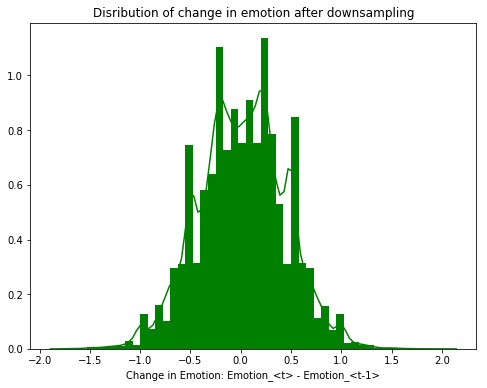

In [69]:
# distribution of change in emotion
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(downsampled_y_train, kde=True, color='green', hist_kws=dict(alpha=1))
plt.xlabel('Change in Emotion: Emotion_<t> - Emotion_<t-1>')
plt.title('Disribution of change in emotion after downsampling')
plt.show()

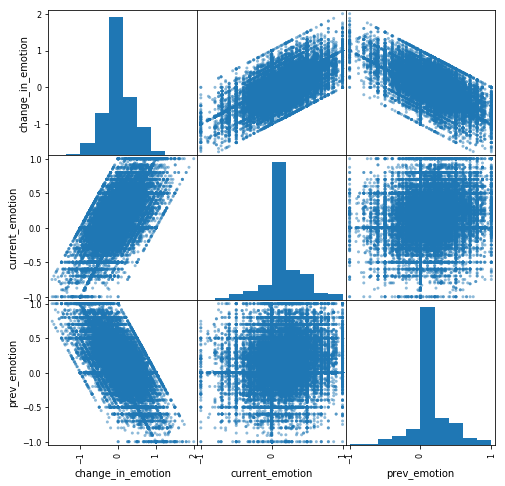

In [49]:
emotions_df = pd.DataFrame(conversations_list)
pd.plotting.scatter_matrix(emotions_df, figsize=(8, 8))
plt.title('distribution of emotions')
plt.show()